# Import des librairies

In [11]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
from matplotlib import rcParams
from collections import Counter
import random
from tqdm import tqdm
from scipy import stats


import tensorflow as tf
from tensorflow import keras 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences


#Paramètres graphiques 
rcParams['figure.figsize'] = 15,8 #Taille de la figure affichée
sns.set_style("darkgrid")#style de l'arrière plan de seaborn 
sns.set_palette("pastel")#Couleurs utilisées dans les graphiques 
plt.rcParams["figure.dpi"] = 200 #dpi = dot per inch , résolution des graphiques 
pd.set_option('display.max_columns', 500) #Nombre de colonne maximum du dataframe à afficher

import warnings
warnings.simplefilter(action='ignore')

In [12]:
def check_nan(df):
    for i in df.columns.tolist():
        print("Valeurs nan dans "+str(i)+" : "+str(df[i].isna().sum()))
        
def check_unique(df):
    for i in df.columns.tolist():
        print("Valeurs uniques dans "+str(i)+" : "+str(df[i].nunique()))
        
def data_reading(df, cols_to_list, cols_to_string, cols_to_date) :
    for col in cols_to_list : 
        df[col] = df[col].apply(lambda data : eval(str(data)) if str(data)!="nan" else [] )
        
    for col in cols_to_string : 
        df[col]= df[col].astype(str)
        
    for col in cols_to_date : 
        df[col] = pd.to_datetime(df[col])
                
    return df 

# Chargement des données

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
data_path="/content/drive/MyDrive/WebScrapping/data/"
model_path="/content/drive/MyDrive/WebScrapping/model/"

In [15]:
data= pd.read_csv(data_path+"data_brut_IA.csv",sep=";")
print("Shape dataframe :",data.shape)
check_nan(data)
print()
check_unique(data)

df = data_reading(data, cols_to_list=["genres","realisateurs","scenaristes","acteurs","pays_origine","langue_origine"],
                        cols_to_string=["titre","support"],
                        cols_to_date=["date_sortie"])

df["note_moyenne_presse"]=df["note_moyenne_presse"].astype(str).apply(lambda note : np.float64(note.replace(",",".")) if note !="nan" else np.nan)
df["note_moyenne_spectateurs_allocine"]=df["note_moyenne_spectateurs_allocine"].astype(str).apply(lambda note : np.float64(note.replace(",",".")) if note !="nan" else np.nan)

df.head(2)

Shape dataframe : (19882, 15)
Valeurs nan dans id : 0
Valeurs nan dans titre : 0
Valeurs nan dans date_sortie : 0
Valeurs nan dans support : 69
Valeurs nan dans duree : 202
Valeurs nan dans genres : 0
Valeurs nan dans realisateurs : 148
Valeurs nan dans scenaristes : 703
Valeurs nan dans acteurs : 149
Valeurs nan dans pays_origine : 2953
Valeurs nan dans langue_origine : 2953
Valeurs nan dans budget : 11504
Valeurs nan dans note_moyenne_presse : 10349
Valeurs nan dans note_moyenne_spectateurs_allocine : 113
Valeurs nan dans note_moyenne_spectateurs_sc : 2538

Valeurs uniques dans id : 19882
Valeurs uniques dans titre : 19051
Valeurs uniques dans date_sortie : 6009
Valeurs uniques dans support : 28
Valeurs uniques dans duree : 213
Valeurs uniques dans genres : 1798
Valeurs uniques dans realisateurs : 8633
Valeurs uniques dans scenaristes : 16578
Valeurs uniques dans acteurs : 19716
Valeurs uniques dans pays_origine : 2182
Valeurs uniques dans langue_origine : 2203
Valeurs uniques dans b

,id,titre,date_sortie,support,duree,genres,realisateurs,scenaristes,acteurs,pays_origine,langue_origine,budget,note_moyenne_presse,note_moyenne_spectateurs_allocine,note_moyenne_spectateurs_sc
0,178014,avatar : la voie de l'eau,2022-12-14,en salle,192.0,"[Science fiction, Aventure, Fantastique, Action]",[1066],"[49984, 1066, 1066, 49985, 49984, 49985, 77617...","[41339, 34515, 259, 6407, 12973, 22533, 130952...",[United States],[English],350000000.0,4.1,4.3,3.45
1,281293,les banshees d'inisherin,2022-12-28,en salle,114.0,[Drame],[142452],[142452],"[41623, 21353, 101150, 646346, 60312, 178500, ...","[Ireland, United Kingdom, United States]",[English],NaN,3.8,3.9,3.65


# Prepocessing

## Dates

In [16]:
df["annee_sortie"] = df["date_sortie"].dt.year
df["mois_sortie"] = df["date_sortie"].dt.month
df["jour_semaine"] = df["date_sortie"].dt.dayofweek

## Valeurs nan

In [17]:
df["duree"]= df["duree"].fillna(df["duree"].mean())
df["budget"]=df["budget"].fillna(df["budget"].quantile(0.25))

# Feature importance

Pour déterminer l'importance des variables dans le modèle, nous allons pour chaque variable 100 fois :
* Fixer les autres variables aléatoirement 
* Prédire les notes pour 10000 combinaisons différentes de la variable testée en laissant fixes les autres variables
* Calculer la variance du résultat prédit sur ces 10000 combinaisons 
* Faire la moyenne des 100 variances obtenues 

On suppose que les variables avec une forte variance, sont celles qui influencent le plus la prédiction du modèle. 

## Fonctions pour générer les valeurs aléatoires des variables testées 

In [18]:
def generate_random_combinations_quanti(df,col,size) : 
    values_kept=[]

    outliers_factors ={"budget":3,"duree":3, "annee_sortie":3 ,"mois_sortie":3, "jour_semaine":3}

    

    if df[col].max()-df[col].min()<size : 
        values_kept = [i for i in range(int(df[col].min()),int(df[col].max()))] 
    
    else :
        df=df[(np.abs(stats.zscore(data[col]))<outliers_factors[col])]
        mean =df[col].mean()
        std = df[col].std()
        for i in range(size) : 
            random_value = int(np.random.normal(loc =mean ,scale =std))
            while random_value in values_kept or random_value<0: 
                random_value = int(np.random.normal(loc =mean ,scale =std))
            values_kept.append(random_value)
    return values_kept

def generate_random_combinations_list_quali(df,col,size): 
    values_kept=[] 
    all_values_df = df[col].sum()
    mean = df[col].apply(lambda list_values : len(list_values)).mean()
    std= df[col].apply(lambda list_values : len(list_values)).std()

    for i in range(size): 
        nb_values =int(np.random.normal(loc =mean ,scale =std))
        value_list=[]
        for j in range(nb_values) : 
            random_value = random.choice(all_values_df)
            while random_value in value_list : 
                random_value=random.choice(all_values_df)
            value_list.append(random_value)
        values_kept.append(value_list)

    return values_kept

## Fonction pour générer les valeurs des variables non testées

Ce sont des valeurs aléatoires piochées dans les valeurs existantes dans le dataset.

In [19]:
def random_other_values(df, cols) :
    dict_values={}
    for col in cols : 
        dict_values[col] = df[col].sample().iloc[0]
    return dict_values

## Fonctions pour générer le dataset sur lequel on fait les prédictions 

In [20]:
def generate_dataframe_one_value_changing(df,col_tested,max_size) : 
    other_cols = df.columns.tolist()
    other_cols.remove(col_tested)

    values_changing = []

    if df[col_tested].dtype == 'float64' or df[col_tested].dtype=='int64' : 
        values_changing=generate_random_combinations_quanti(df,col_tested,max_size)

    elif df[col_tested].dtype == "object" : 
        values_changing=generate_random_combinations_list_quali(df,col_tested,max_size)

    new_df= pd.DataFrame()
    new_df[col_tested] =values_changing
    dict_other_values = random_other_values(df, other_cols)

    for key,value in dict_other_values.items() :  
        new_df[key] = [value for i in range(len(new_df))]
    
    return new_df

### Test de la fonction

In [21]:
%%time
test =generate_dataframe_one_value_changing(df, "duree",10000)
test.head(2)

CPU times: user 23.8 ms, sys: 1.67 ms, total: 25.5 ms
Wall time: 28.3 ms


,duree,id,titre,date_sortie,support,genres,realisateurs,scenaristes,acteurs,pays_origine,langue_origine,budget,note_moyenne_presse,note_moyenne_spectateurs_allocine,note_moyenne_spectateurs_sc,annee_sortie,mois_sortie,jour_semaine
0,21,253969,ca ira mieux demain,2020-04-28,en salle,"[Drame, Comédie]",[232444],"[85221, 199802, 169072, 149485]","[18856, 8402, 49187, 16472, 17615, 11217, 5212...",[Germany],[],20000000.0,NaN,2.5,3.15,1986,3,2
1,22,253969,ca ira mieux demain,2020-04-28,en salle,"[Drame, Comédie]",[232444],"[85221, 199802, 169072, 149485]","[18856, 8402, 49187, 16472, 17615, 11217, 5212...",[Germany],[],20000000.0,NaN,2.5,3.15,1986,3,2


## Pipeline de mise en forme des données pour mesurer l'importance des variables

In [22]:
def convert_np_array(array_init) :
    array_lists =[]
    for i in range(len(array_init)): 
        array_lists.append(list(array_init.values[i]))
    return np.array(array_lists)

def pipeline_final_data_pred(df_model, embeds,list_tokenizers,col_tested,size):
    #Création du dataframe pour la prédiction
    df_testing= generate_dataframe_one_value_changing(df_model, col_tested,size)

    #Texts to sequences : 
    for index, embed in enumerate(embeds) : 
        for col in embed : 
            df_testing[col]= list_tokenizers[index].texts_to_sequences(df_testing[col]) 
    
    #Padding : 
    MAX_LENGTH_SEQ=8
    for index, embed in enumerate(embeds) : 
        for col in embed : 
            df_testing[col]= list(pad_sequences(df_testing[col], maxlen=MAX_LENGTH_SEQ, padding="post") )


    #Mise en forme : 
    X_pred_e0 = df_testing.loc[:,embeds[0]]
    X_pred_e1 = df_testing.loc[:,embeds[1]]
    X_pred_e2 = df_testing.loc[:,embeds[2]]
    X_pred_e3 = df_testing.loc[:,embeds[3]]
    X_pred_e4 = df_testing.loc[:,embeds[4]]
    X_pred_rest = df_testing.drop(columns=np.sum(embeds))

    X_pred_e0=X_pred_e0.apply(lambda row : np.array(list(row.acteurs) + list(row.realisateurs) + list(row.scenaristes)) ,axis=1)

    X_pred_e0=convert_np_array(X_pred_e0).astype(float)
    X_pred_e1=convert_np_array(X_pred_e1)
    X_pred_e2=convert_np_array(X_pred_e2)
    X_pred_e3=convert_np_array(X_pred_e3)
    X_pred_e4=convert_np_array(X_pred_e4)

    X_pred_e1=X_pred_e1.reshape(X_pred_e1.shape[0],X_pred_e1.shape[2]).astype(float)
    X_pred_e2=X_pred_e2.reshape(X_pred_e2.shape[0],X_pred_e2.shape[2]).astype(float)
    X_pred_e3=X_pred_e3.reshape(X_pred_e3.shape[0],X_pred_e3.shape[2]).astype(float)
    X_pred_e4=X_pred_e4.reshape(X_pred_e4.shape[0],X_pred_e4.shape[2]).astype(float)

    #Normalisation des données : 
    scaler = preprocessing.MinMaxScaler()
    scaler.fit(df_model.loc[:,X_pred_rest.columns])
    X_pred_rest_scaled =scaler.transform(X_pred_rest)

    #Regroupement :
    values_for_pred = [X_pred_rest_scaled,X_pred_e0,X_pred_e1,X_pred_e2,X_pred_e3,X_pred_e4]

    return values_for_pred

In [23]:
def feature_importance_model(df, model, nb_iterations, size_max) : 
    dict_results={}
    for col_tested in tqdm(df.columns) : 
        variances_iterations =[]
        for i in range(nb_iterations) :
            to_pred = pipeline_final_data_pred(df,embeds,list_tokenizers,col_tested,size_max)
            variances_iterations.append(np.std(model.predict(to_pred,verbose=0).reshape(len(to_pred[0]))))
        dict_results[col_tested] = np.mean(variances_iterations)

    df_results = pd.DataFrame()
    df_results["Feature"]=dict_results.keys()
    df_results["mean_std"] =dict_results.values() 
    return df_results

### Création des variables

In [24]:
df_model=df.copy(deep=True).drop(columns=["id","titre","date_sortie","note_moyenne_presse","note_moyenne_spectateurs_allocine","note_moyenne_spectateurs_sc"])

In [25]:
#Embeddings :
cols_embed0 = ["acteurs","realisateurs","scenaristes"]
cols_embed1 =["genres"]
cols_embed2 =["langue_origine"]
cols_embed3 = ["pays_origine"]
cols_embed4 =["support"]
embeds = [cols_embed0, cols_embed1,cols_embed2,cols_embed3,cols_embed4]

#Tokenizers : 
list_tokenizers = []
list_word_index=[]
dict_max_nb_words= {0:512,1:16,2:16,3:16,4:16 }

for i,embed in enumerate(embeds) : 
    values_to_encode=pd.concat([df_model[col].apply(lambda list_words : " ".join(list_words) if type(list_words)==list else list_words) for col in embed])
    tokenizer=tf.keras.preprocessing.text.Tokenizer(
        num_words=dict_max_nb_words[i],
        oov_token=""
    )
    tokenizer.fit_on_texts(values_to_encode)
    list_word_index.append(tokenizer.word_index)
    list_tokenizers.append(tokenizer)

# Feature importance par modèle 

## Spectateurs Allociné

### Chargement du modèle

In [26]:
model = keras.models.load_model(model_path+"note_moyenne_specs_allocine.h5")
model.summary()

Model: "model_96"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_109 (InputLayer)         [(None, 24)]         0           []                               
                                                                                                  
 input_110 (InputLayer)         [(None, 8)]          0           []                               
                                                                                                  
 input_111 (InputLayer)         [(None, 8)]          0           []                               
                                                                                                  
 input_112 (InputLayer)         [(None, 8)]          0           []                               
                                                                                           

### Test des variables

In [27]:
%%time
df_results= feature_importance_model(df_model, model, 100,10000)
df_results.head()

100%|██████████| 12/12 [50:22<00:00, 251.87s/it]

CPU times: user 47min 7s, sys: 1min 2s, total: 48min 10s
Wall time: 50min 22s


,Feature,mean_std
0,support,0.038262
1,duree,0.572157
2,genres,0.196659
3,realisateurs,0.050501
4,scenaristes,0.075567


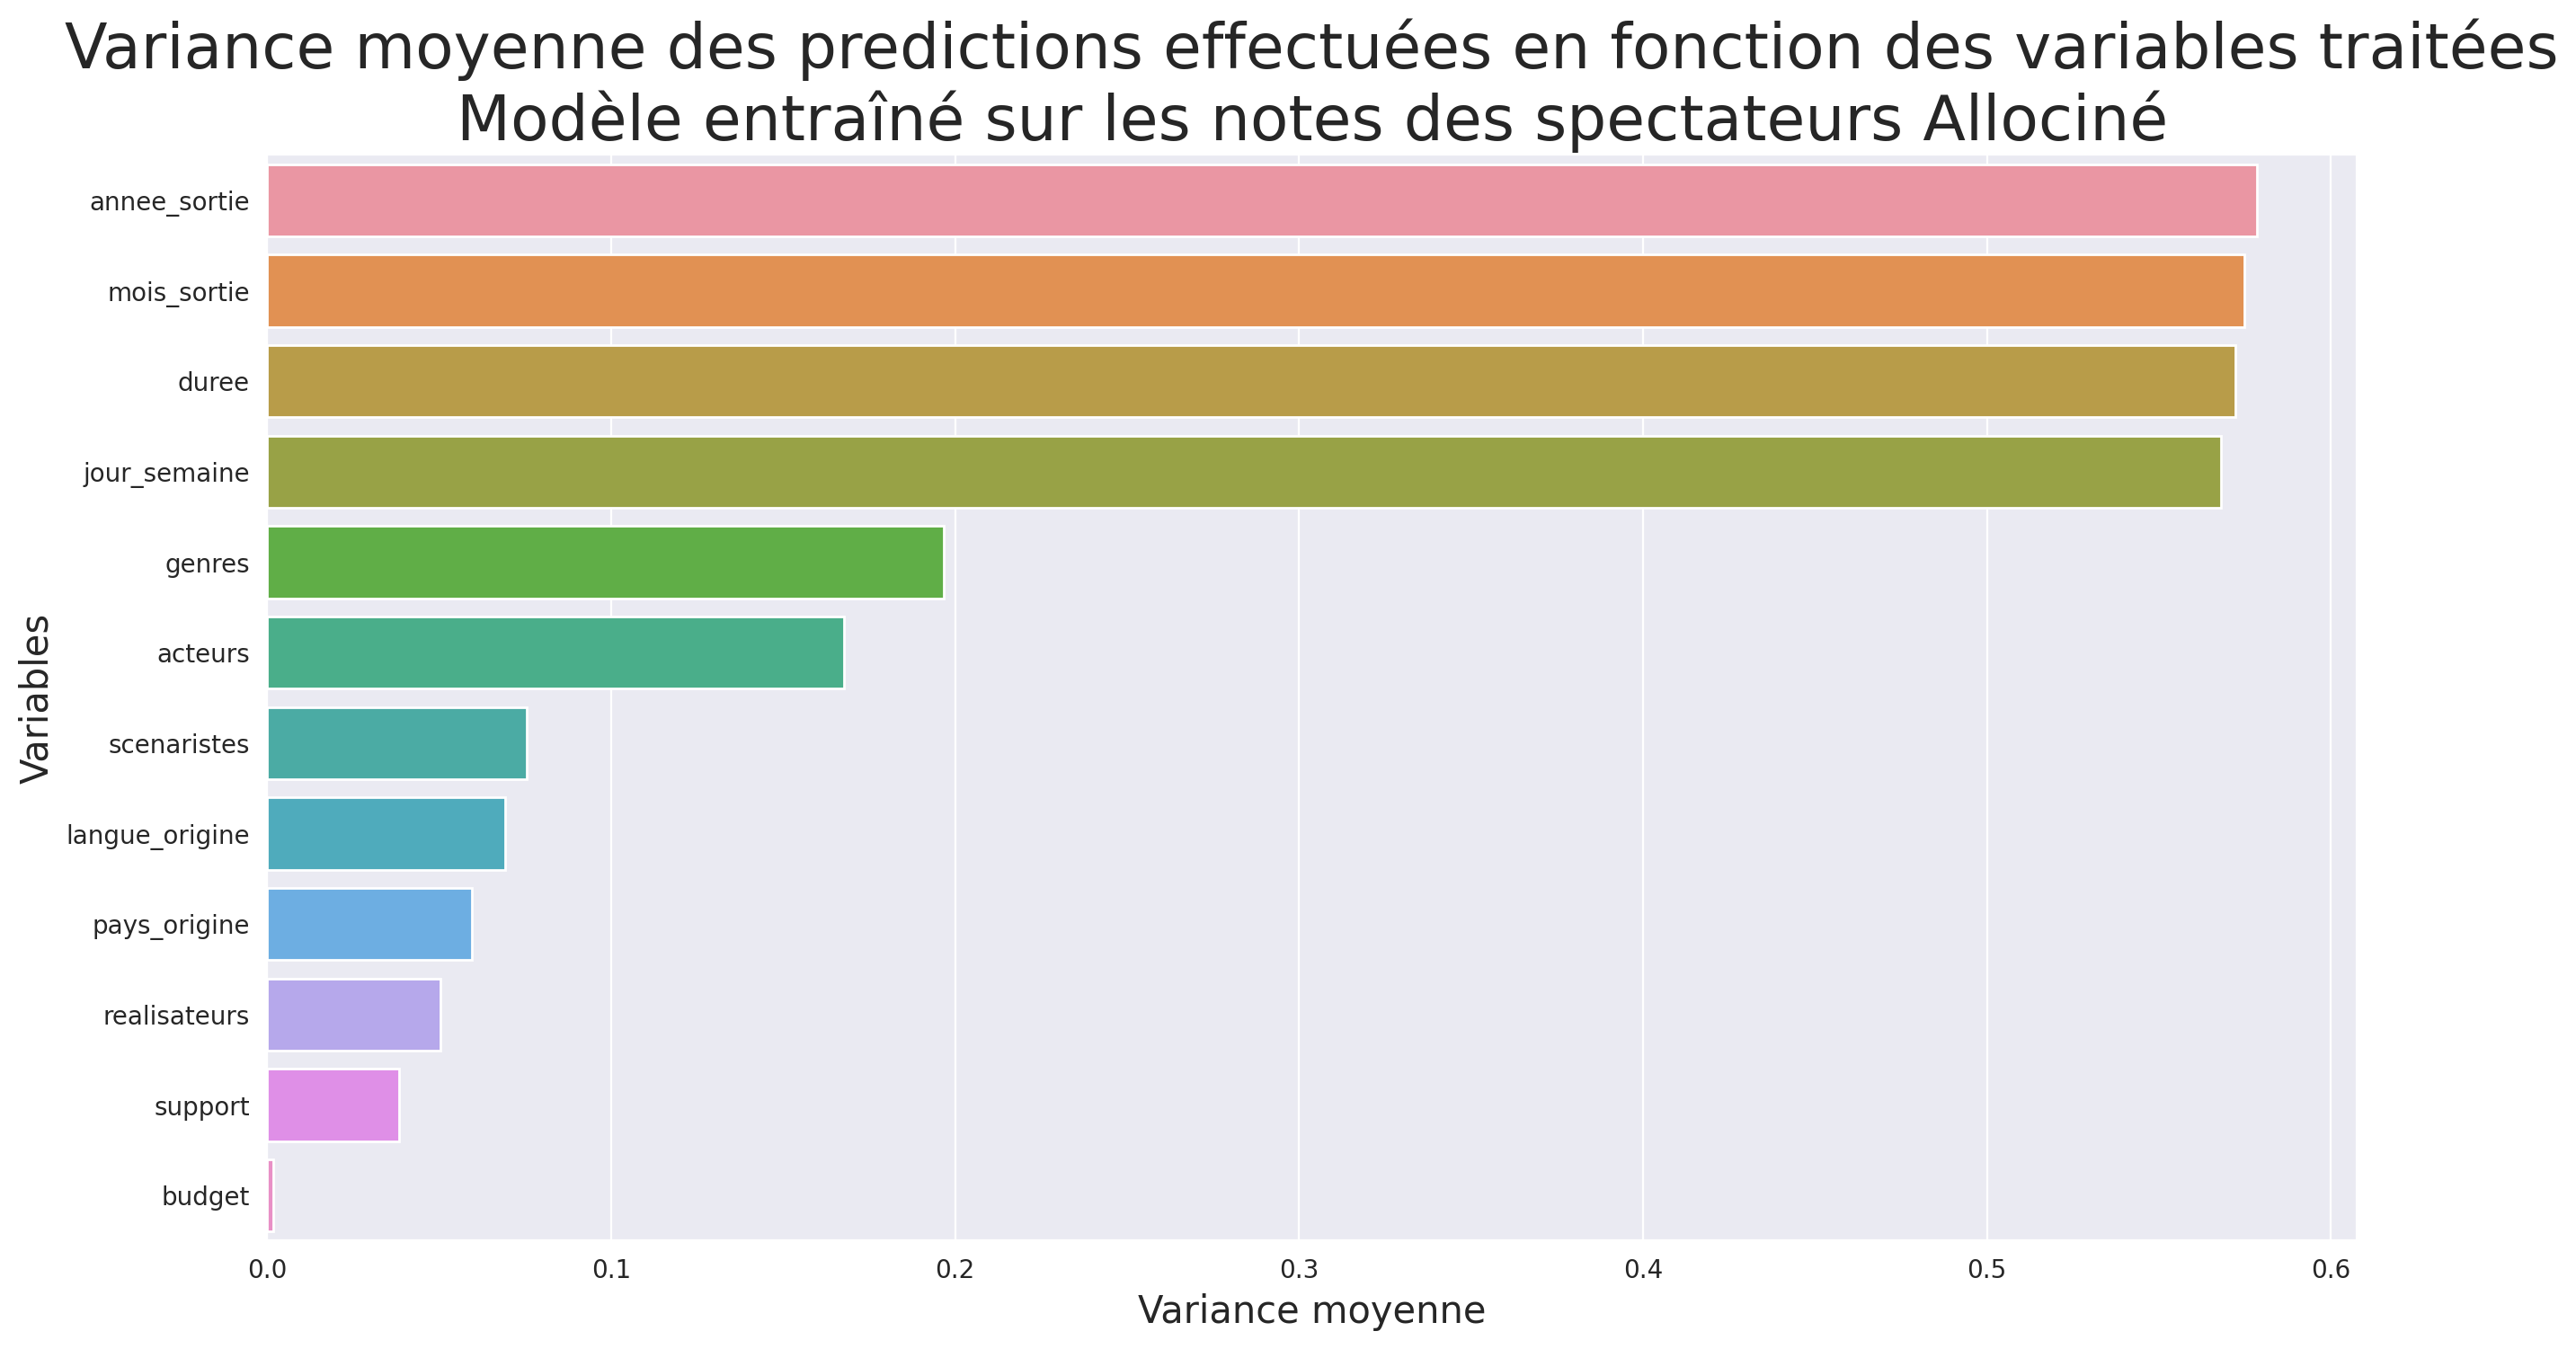

In [28]:
sns.barplot(data=df_results.sort_values("mean_std",ascending=False),x="mean_std",y="Feature")
plt.xlabel("Variance moyenne",fontsize=15)
plt.ylabel("Variables",fontsize=15)
plt.title("Variance moyenne des predictions effectuées en fonction des variables traitées\nModèle entraîné sur les notes des spectateurs Allociné",fontsize=25)
plt.show()